## Filtering & Plots

This notebook is for streamlining the filtering process that occurs after ipyrad. This way, I can rerun the notebook with different filenames instead of do it from scratch each time.


**[1]** Change working directory to assembly outfiles

In [1]:
cd /mnt/hgfs/SHARED_FOLDER/Learn_iPyrad/CRAGIG_RUNS_12_py/CG_l1_25_c86_H_outfiles/

/mnt/hgfs/SHARED_FOLDER/Learn_iPyrad/CRAGIG_RUNS_12_py/CG_l1_25_c86_H_outfiles


In [2]:
# get name of VCF file
!ls *.vcf

CG_l1_25_c86_H.vcf


**[2]** Make directory for new/edited outfiles from ipyrad, called ``new_outfiles``.

In [211]:
!mkdir new_outfiles

**[3]** Use ``vcftools`` to filter for biallelic loci and minor allele frequency. Manual [here](http://vcftools.sourceforge.net/man_latest.html).

Be sure to change:
- name of input vcf file
- name of output vcf file

Use: 
- ``--maf`` for minor allele frequency
- ``--recode-INFO-all`` to keep info column data
- ``--recode`` to make a new filtered file

In [212]:
!vcftools --vcf CG_l1_25_c86_H.vcf \
--min-alleles 2 \
--max-alleles 2 \
--out new_outfiles/CG_l1_25_c86_H_biall_NOmaf \
--recode-INFO-all \
--recode


VCFtools - UNKNOWN
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf CG_l1_25_c86_H.vcf
	--recode-INFO-all
	--max-alleles 2
	--min-alleles 2
	--out new_outfiles/CG_l1_25_c86_H_biall_NOmaf
	--recode

After filtering, kept 25 out of 25 Individuals
Outputting VCF file...
After filtering, kept 89916 out of a possible 93678 Sites
Run Time = 3.00 seconds


**[4]** Get one SNP per RAD tag

A collaborator made a script to get one SNP per RAD tag (one with highest coverage). If there's a tie between SNPs, it picks the one closest to the beginning of the read. Script [here](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_combined_lanes/Scripts/subsetSNPs_KS.py).

Be sure to change:
- name of input VCF file
- name of output VCF file

In [4]:
import os
os.chdir("new_outfiles")

In [5]:
!python ../../oneSNP.py \
CG_l1_25_c86_H_biall_NOmaf.recode.vcf \
CG_l1_25_c86_H_biall_NOmaf_oneSNP.vcf

Total SNPS: 89928
Unlinked SNPs: 9157


**[5]** Make dictionary for translating STR file locus names to VCF file locus names

In a few steps, we will use [PGD Spider](http://www.cmpg.unibe.ch/software/PGDSpider/) to convert the filtered VCF file into a STR file, which can be read into ``adegenet`` for population genetic statistics. However, PGD Spider will give loci arbitrary names: SNP_1, SNP_2, SNP_3, etc. So, we will need to give them informative names based on the locus number and position in the VCF file in order to make use of the population genetic statistics.

Be sure to change the name of the filtered VCF file. Your filtered vcf file will be the name you gave it plus ``.recode.vcf``

In [215]:
vcf_filename = "CG_l1_25_c86_H_biall_NOmaf_oneSNP.vcf" # biall, maf, onesnp

In [216]:
vcf_file = open(vcf_filename,"r") # change!
vcf_file_lines = vcf_file.readlines()
vcf_file.close()

# double check number of loci
count = 0
for line in vcf_file_lines:
    if line[0] != "#":
        count += 1
        
print "Number of loci: " + str(count)

locus_names = {}
snp_name_count = 1

for line in vcf_file_lines:
    if line[0] != "#":
        linelist = line.strip().split()
        locus = linelist[0]
        pos = linelist[1]
        vcf_locus_name = locus + "_" + pos
        str_locus_name = "SNP_" + str(snp_name_count)
        snp_name_count += 1
        locus_names[str_locus_name] = vcf_locus_name   

Number of loci: 9157


**[6]** Extract read depth information by locus from VCF file.

This block of code will make a dictionary with the VCF locus file names as keys and lists of read depths (across samples) as values. Plot average read depth (across samples) per locus.

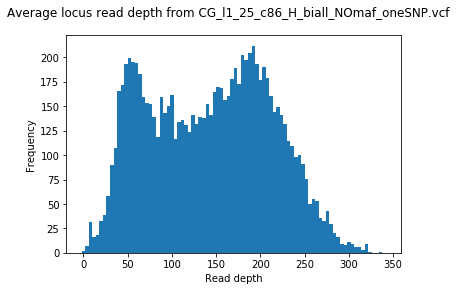

In [217]:
sample_list = []
snp_name_list = []
rdd = {} 

for line in vcf_file_lines:
    if line[0:1] == "#C":
        linelist = line.strip().split()
        sample_list += linelist[9:]
    elif line[0] != "#": # ignore header lines
        genblocks = line.strip().split()
        snp_name = genblocks[0] + "_" + genblocks[1] # name format e.g., locus_47_1
        snp_name_list.append(snp_name)
        for genblock in genblocks[9:]: # start on genotype lines
            genblocklist = genblock.split(":")
            rd = int(genblocklist[1])
            if snp_name not in rdd:
                rdd[snp_name] = [rd]
            elif snp_name in rdd:
                rdd[snp_name] += [rd]
            else:
                print "something funky going on"
                
import matplotlib.pyplot as plt
import numpy as np

locus_rd_avs = []
for snp in snp_name_list:
    locus_rd_avs.append(np.mean(rdd[snp]))
    
plt.hist(locus_rd_avs, bins = np.arange(0,max(locus_rd_avs),4)-2)
plt.suptitle("Average locus read depth from " + vcf_filename)
plt.xlabel("Read depth")
plt.ylabel("Frequency")
plt.show()

**[6]** Make STR file out of filtered VCF using PGD Spider. 

This is done in the GUI.

Select input filetype as VCF, and output filetype as STR. Select your filtered VCF file as your input file, and select a name for your output file, including the .str extension. For the VCF Parser Questions, default parameters are fine. For the STR Writer Questions, be sure to change data type to SNPs.

Enter your output structure file name here:

In [218]:
str_filename = "CG_l1_25_c86_H_biall_NOmaf_oneSNP.str" # change!

![img](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_combined_lanes/Notebooks/imgs_for_notebooks/vcf_parser.png?raw=true)


![img](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_combined_lanes/Notebooks/imgs_for_notebooks/snp_writer.png?raw=true)

**[8]** Rename header of STR file using dictionary created in Step 4.

Enter the name for your STR filename with new locus names here.

In [219]:
new_str_filename = "CG_l1_25_c86_H_biall_NOmaf_oneSNP_inames.str" # change!

In [220]:
str_file = open(str_filename, "r")
str_file_lines = str_file.readlines()
str_file.close()

new_str_header = "\t\t" # will need to change this line when I get a hold of better code for one SNP/tag
old_str_header_list = str_file_lines[0].strip().split()
for snpname in snp_name_list:
    new_str_header += snpname + " "
new_str_header = new_str_header[:-1]
new_str = open(new_str_filename, "w")
new_str.write(new_str_header + "\n")
for line in str_file_lines[1:]:
    new_str.write(line)
new_str.close()

**[9]** Add population information (OPTIONAL)

When I have all of my samples, I'll definitely want to include population information in the STR file. However, as I have small sample sizes per population now, I'd rather leave it out and check out my data as if all populations are one.

Be sure to change the name of your population map and name of STR file with population info here:

In [82]:
popmap_name = "popmap_cragig_sansAs.txt"
str_filename_w_pops = "cragig_lanes_12_002_biall_maf_onesnp__inames_wpops.str"

In [156]:
popfile = open("../" + popmap_name,"r")
popfile_lines = popfile.readlines()
popfile.close()

In [157]:
str_onesnp_file = open(new_str_filename, "r")
str_onesnp_file_lines = str_onesnp_file.readlines()
str_onesnp_file.close()

In [158]:
pop_dict = {}
sample_list = []

for line in popfile_lines:
    linelist = line.strip().split()
    sample = linelist[0]
    sample_list.append(sample)
    popnum = linelist[1][-1]
    pop_dict[sample] = popnum
    
lines_for_file = []
lines_for_file.append(str_onesnp_file_lines[0])

for line in str_onesnp_file_lines[1:]: # exclude header
    linelist = line.strip().split()
    samplename = linelist[0]
    newpopnum = pop_dict[samplename]
    genotypes = ""
    for genotype in linelist[2:]: # exclude sample name and pop id columns
        genotypes += genotype + " "
    genotypes = genotypes[:-1] # get rid of last space
    newline = samplename + "\t" + newpopnum + "\t" + genotypes + "\n"
    lines_for_file.append(newline)
    
str_file_w_pops = open(str_filename_w_pops,"w")
for line in lines_for_file:
    str_file_w_pops.write(line)
str_file_w_pops.close()

**[10]** Add fake second population to be able to look at populations as one in ``hierfstat``

Before I have all of my samples, it makes sense to look at population genetic statistics like Fis distribution and heterozygosity across all of my samples. However, ``hierfstat`` can't calculate these statistics on just one population. So, I can make a false second population just to get it running.

Be sure to change the name of the output STR file with false population here:

In [221]:
str_filename_fpop = "CG_l1_25_c86_H_biall_NOmaf_oneSNP_inames_fpop.str"

In [222]:
str_onesnp_file = open(new_str_filename, "r")
str_onesnp_file_lines = str_onesnp_file.readlines()
str_onesnp_file.close()

fpop_lines = []

for line in str_onesnp_file_lines[-6:]:
    linelist = line.strip().split()
    newline = "FALSE" + linelist[0] + "\t" + "2" + "\t"
    for genotype in linelist[2:]:
        newline += genotype + " "
    newline = newline[:-1] + "\n"
    fpop_lines.append(newline)

str_file_fpop =open(str_filename_fpop, "w")

for line in str_onesnp_file_lines:
    str_file_fpop.write(line)
for line in fpop_lines:
    str_file_fpop.write(line)
str_file_fpop.close()

numloci = len(str_onesnp_file_lines[0].strip().split())
numinds = int(float(len(fpop_lines)+len(str_onesnp_file_lines)-1))/float(2)

print "Number of individuals after adding fpop = " + str(numinds) 
print "Number of loci = " + str(numloci)


Number of individuals after adding fpop = 28.0
Number of loci = 9157


## Get pop gen stats with heirfstat

I made an R script that will read the structure file in with adegenet, and then calculate Ho, Hs, and Fis across loci. Script [here](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_combined_lanes/Scripts/pop_gen_stats.R).

In [180]:
pwd

u'/mnt/hgfs/SHARED_FOLDER/Learn_iPyrad/CRAGIG_RUNS_12_py/CG_l1_25_c82_H_outfiles/new_outfiles'

In [223]:
# get working directory from results to cell above
wd = "/mnt/hgfs/SHARED_FOLDER/Learn_iPyrad/CRAGIG_RUNS_12_py/CG_l1_25_c86_H_outfiles/new_outfiles"

# 8 digit date for naming files
date = "20170713"

In [224]:
# run R script

import subprocess as sp

string_callR = "Rscript ../../../../pop_gen_stats.R "
string_callR += wd + " "
string_callR += str_filename_fpop + " "
string_callR += str(numinds) + " " + str(numloci) + " " + date

sp.call([string_callR],shell=True)

0

## Plots

The code here comes from my [Exploratory Plots notebook](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_combined_lanes/Notebooks/Exploratory%20Plots.ipynb). For streamlining my workflow, it's handy to have here too.

In [41]:
ls *.txt

Fis_20170711_fpop.txt*  Ho_20170711_fpop.txt*  Hs_20170711_fpop.txt*
Fis_ 20170713 .txt*     Ho_ 20170713 .txt*     Hs_ 20170713 .txt*


In [36]:
import matplotlib.pyplot as plt
import numpy as np

In [225]:
assembly_name_plots = vcf_filename.split(".")[0]
str_filename = str_filename_fpop
fis_filename = "Fis_" + date + ".txt"
ho_filename = "Ho_" + date + ".txt"
hs_filename = "Hs_" + date + ".txt"
clust_sim = "86%" # CHANGE

In [226]:
vcf_file = open(vcf_filename,"r") # change!
vcf_file_lines = vcf_file.readlines()
vcf_file.close()

locus_names = {}
snp_name_count = 1

for line in vcf_file_lines:
    if line[0] != "#":
        linelist = line.strip().split()
        locus = linelist[0]
        pos = linelist[1]
        vcf_locus_name = locus + "_" + pos
        str_locus_name = "SNP_" + str(snp_name_count)
        snp_name_count += 1
        locus_names[str_locus_name] = vcf_locus_name  

sample_list = []
snp_name_list = []
rdd = {} 

for line in vcf_file_lines:
    if line[0:1] == "#C":
        linelist = line.strip().split()
        sample_list += linelist[9:]
    elif line[0] != "#": # ignore header lines
        genblocks = line.strip().split()
        snp_name = genblocks[0] + "_" + genblocks[1] # name formate.g., locus_47_1
        snp_name_list.append(snp_name)
        for genblock in genblocks[9:]: # start on genotype lines
            genblocklist = genblock.split(":")
            rd = int(genblocklist[1])
            if snp_name not in rdd:
                rdd[snp_name] = [rd]
            elif snp_name in rdd:
                rdd[snp_name] += [rd]
            else:
                print "something funky going on"

locus_rd_avs = []
for snp in snp_name_list:
    locus_rd_avs.append(np.mean(rdd[snp]))
    
plt.hist(locus_rd_avs, bins = np.arange(0,max(locus_rd_avs)+1,4)-2)
plt.title("Average locus read depth " + vcf_filename + "\n" + clust_sim)
plt.xlabel("Read depth")
plt.ylabel("Frequency")

plt.savefig('rd_' + assembly_name_plots + '.png')
plt.close()

In [227]:
fis_file = open(fis_filename,"r")
fis_file_lines = fis_file.readlines()
fis_file.close()

fis_list = []
fis_pls_NAs = []

for line in fis_file_lines[1:]:
    fis = line.strip().split()[1]
    fis_pls_NAs.append(fis)
    if fis != "NA":
        fis_list.append(float(fis))
    
plt.hist(fis_list, bins = np.arange(-1.2,1.2,.05)-.025)


plt.title(fis_filename + "\n" + clust_sim)

plt.xlabel("Fis")
plt.ylabel("Frequency")

plt.savefig("Fis_" + assembly_name_plots + '.png')
plt.close()

In [228]:
ho_file = open(ho_filename,"r")
ho_file_lines = ho_file.readlines()
ho_file.close()

ho_list = []
ho_and_NAs = []

for line in ho_file_lines[1:]:
    ho = line.strip().split()[1]
    ho_and_NAs.append(ho)
    if ho != "NA":
        ho_list.append(float(ho))
    
plt.hist(ho_list, bins = np.arange(0,1.2,.05)-.025)

plt.title(ho_filename + "\n" + clust_sim)
plt.xlabel("Ho")
plt.ylabel("Frequency")
plt.savefig("Ho_" + assembly_name_plots + '.png')
plt.close()

In [229]:
hs_file = open(hs_filename,"r")
hs_file_lines = hs_file.readlines()
hs_file.close()

hs_list = []
hs_and_NAs = []

for line in hs_file_lines[1:]:
    hs = line.strip().split()[1]
    hs_and_NAs.append(hs)
    if hs != "NA":
        hs_list.append(float(hs))
    
plt.hist(hs_list, bins = np.arange(0,1.2,.025)-.0125)

plt.title(hs_filename + "\n" + clust_sim)

plt.xlabel("Hs")
plt.ylabel("Frequency")
plt.savefig("Hs_" + assembly_name_plots + '.png')
plt.close()

In [232]:
pwd

u'/mnt/hgfs/SHARED_FOLDER'